# Setup and installation

In [1]:
!pip install -q numpy==1.26.4 pandas==2.3.3
!pip install -q scipy==1.15.3 scikit-learn==1.7.2
!pip install -q matplotlib==3.10.7 seaborn==0.13.2 networkx==3.4.2

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
import os
import random
import numpy as np

from sklearn.utils import check_random_state

SEED = 25
DATA_FOLDER = 'data/'
min_count = 20
K = 10

def set_seed():
    os.environ["PYTHONHASHSEED"] = str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    sklearn_random_state = check_random_state(SEED)

    print(f"All seeds set to {SEED}")

def download_initial_data():
    os.makedirs(DATA_FOLDER, exist_ok=True)
    !wget -O "{DATA_FOLDER}groceries.csv" -q https://raw.githubusercontent.com/murodbecks/groceries_analysis/refs/heads/main/data/groceries.csv

    print(f"Initial data is saved to '{DATA_FOLDER}groceries.csv' file")

set_seed()
download_initial_data()

All seeds set to 25
Initial data is saved to 'data1/groceries.csv' file


# A. Load & Understand

In [4]:
import pandas as pd

df_raw = pd.read_csv(f"{DATA_FOLDER}groceries.csv", header=None, names=['groceries'], 
                     sep="__NON_EXISTENT_SEPARATOR__")
df_raw['groceries'] = df_raw['groceries'].astype(str)
df_raw.head(5)

,groceries
0,"citrus fruit,semi-finished bread,margarine,rea..."
1,"tropical fruit,yogurt,coffee"
2,whole milk
3,"pip fruit,yogurt,cream cheese ,meat spreads"
4,"other vegetables,whole milk,condensed milk,lon..."


In [5]:
groceries_info = []

for i, row in df_raw.iterrows():
    transaction_id = f"id_{i:04d}"
    items = row['groceries'].split(',')
    groceries_info.append({"transaction_id": transaction_id, "items": items, "basket_size": len(items)})

df = pd.DataFrame(groceries_info)
df.head(5)

,transaction_id,items,basket_size
0,id_0000,"[citrus fruit, semi-finished bread, margarine,...",4
1,id_0001,"[tropical fruit, yogurt, coffee]",3
2,id_0002,[whole milk],1
3,id_0003,"[pip fruit, yogurt, cream cheese , meat spreads]",4
4,id_0004,"[other vegetables, whole milk, condensed milk,...",4


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4472 entries, 0 to 4471
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  4472 non-null   object
 1   items           4472 non-null   object
 2   basket_size     4472 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 104.9+ KB


In [7]:
from collections import Counter

product_counter = Counter()

for products in df['items']:
    product_counter.update(products)


In [8]:
print(f"Number of trasnactions: {len(df)}")
print("----")

print(f"Number of unique items: {len(product_counter)}")
print("----")

print(f"Basket size statistics:")
print(f" - Minimum Value: {df['basket_size'].min()}")
print(f" - Median Value: {int(df['basket_size'].median())}")
print(f" - 95th Percentile Value: {int(df['basket_size'].quantile(0.95))}")
print("----")

print("Top 20 products (with number of occurancy):")
for grocery_item, count in product_counter.most_common(20):
    print(f" - {grocery_item}: {count}")

Number of trasnactions: 4472
----
Number of unique items: 151
----
Basket size statistics:
 - Minimum Value: 1
 - Median Value: 2
 - 95th Percentile Value: 4
----
Top 20 products (with number of occurancy):
 - whole milk: 726
 - soda: 616
 - rolls/buns: 589
 - other vegetables: 421
 - yogurt: 339
 - bottled water: 301
 - pastry: 258
 - newspapers: 240
 - tropical fruit: 211
 - shopping bags: 207
 - citrus fruit: 187
 - root vegetables: 184
 - coffee: 177
 - pip fruit: 162
 - fruit/vegetable juice: 158
 - brown bread: 153
 - whipped/sour cream: 149
 - frankfurter: 144
 - chocolate: 138
 - specialty chocolate: 124


# B. Clean & Transform

In [9]:
def process_items(items: list[str]) -> list[str]:
    processes_items = []

    for grocery_item in items:
        grocery_item = grocery_item.strip().lower()
        grocery_item = grocery_item.replace(" ", "_").replace(".", "")
        if len(grocery_item) >= 1:
            processes_items.append(grocery_item)

    return processes_items

df['items'] = df['items'].apply(process_items)
df['basket_size'] = df['items'].apply(len)

In [10]:
df = df[df['basket_size']>1]
df.reset_index(drop=True, inplace=True)
df

,transaction_id,items,basket_size
0,id_0000,"[citrus_fruit, semi-finished_bread, margarine,...",4
1,id_0001,"[tropical_fruit, yogurt, coffee]",3
2,id_0003,"[pip_fruit, yogurt, cream_cheese, meat_spreads]",4
3,id_0004,"[other_vegetables, whole_milk, condensed_milk,...",4
4,id_0007,"[whole_milk, cereals]",2
...,...,...,...
2815,id_4463,"[pastry, newspapers]",2
2816,id_4464,"[whole_milk, curd, bottled_water]",3
2817,id_4466,"[whole_milk, yogurt, frozen_meals, bottled_water]",4
2818,id_4469,"[yogurt, long_life_bakery_product]",2


In [11]:
df.to_csv(f"{DATA_FOLDER}transactions_clean.csv", index=False)

# C. Assign Prices & Enrich

In [12]:
all_products = set()

for items in df['items']:
    all_products.update(items)

len(all_products)

146

In [13]:
MIN_PRICE = 0.5
MAX_PRICE = 15

rng = np.random.default_rng(SEED)

all_prices = []

for _ in range(len(all_products)):
    random_price = rng.random() * (MAX_PRICE - MIN_PRICE) + MIN_PRICE
    all_prices.append(round(random_price, 2))

In [14]:
df_prices = pd.DataFrame({'product': sorted(list(all_products)), "price": all_prices})
df_prices.head()

,product,price
0,abrasive_cleaner,2.83
1,artif_sweetener,0.50
2,baby_cosmetics,3.64
3,baking_powder,5.84
4,bathroom_cleaner,0.53


In [15]:
df_prices.to_csv(f"{DATA_FOLDER}product_prices.csv", index=False)

In [16]:
price_dictionary = {}

for product, price in zip(all_products, all_prices):
    price_dictionary[product] = price

def get_total_price(items: list[str]) -> float:
    total_price = 0.0
    for product in items:
        total_price += price_dictionary[product]
    
    return round(total_price, 2)

df['basket_total'] = df['items'].apply(get_total_price)
df

,transaction_id,items,basket_size,basket_total
0,id_0000,"[citrus_fruit, semi-finished_bread, margarine,...",4,17.58
1,id_0001,"[tropical_fruit, yogurt, coffee]",3,8.17
2,id_0003,"[pip_fruit, yogurt, cream_cheese, meat_spreads]",4,14.24
3,id_0004,"[other_vegetables, whole_milk, condensed_milk,...",4,38.73
4,id_0007,"[whole_milk, cereals]",2,20.82
...,...,...,...,...
2815,id_4463,"[pastry, newspapers]",2,16.91
2816,id_4464,"[whole_milk, curd, bottled_water]",3,10.28
2817,id_4466,"[whole_milk, yogurt, frozen_meals, bottled_water]",4,19.97
2818,id_4469,"[yogurt, long_life_bakery_product]",2,15.45


In [17]:
df.to_csv(f"{DATA_FOLDER}transactions_clean.csv", index=False)

# D. Co-Occurence Statistics

In [18]:
from itertools import combinations

pair_counter = Counter()
triplet_counter = Counter()

for products in df['items']:
    for product_pair in combinations(sorted(products), 2):
        pair_counter.update([product_pair])
    
    for product_triplet in combinations(sorted(products), 3):
        triplet_counter.update([product_triplet])

len(pair_counter), len(triplet_counter)

(2562, 3037)

In [19]:
if pair_counter.most_common(1)[0][-1] < min_count:
    print(f"There is no product pair with at least {min_count} co-occurance.")
else:
    print(f"Product pairs with at least {min_count} co-occurance:")
    for products, count in pair_counter.most_common():
        if count >= min_count:
            products_str = ', '.join(products)
            print(f" - {products_str} ({count})")


Product pairs with at least 20 co-occurance:
 - rolls/buns, soda (84)
 - rolls/buns, whole_milk (80)
 - other_vegetables, whole_milk (75)
 - bottled_water, soda (49)
 - frankfurter, rolls/buns (48)
 - pastry, whole_milk (48)
 - pastry, soda (47)
 - soda, whole_milk (47)
 - whole_milk, yogurt (46)
 - root_vegetables, whole_milk (45)
 - bottled_water, whole_milk (43)
 - newspapers, whole_milk (42)
 - rolls/buns, yogurt (40)
 - other_vegetables, root_vegetables (39)
 - other_vegetables, rolls/buns (37)
 - tropical_fruit, whole_milk (36)
 - other_vegetables, yogurt (36)
 - bottled_water, rolls/buns (33)
 - pastry, rolls/buns (32)
 - brown_bread, whole_milk (32)
 - citrus_fruit, other_vegetables (32)
 - other_vegetables, soda (32)
 - shopping_bags, soda (31)
 - newspapers, rolls/buns (30)
 - other_vegetables, tropical_fruit (28)
 - margarine, whole_milk (26)
 - whipped/sour_cream, whole_milk (26)
 - citrus_fruit, whole_milk (26)
 - pip_fruit, whole_milk (26)
 - coffee, whole_milk (25)
 - so

In [20]:
if triplet_counter.most_common(1)[0][-1] < min_count:
    print(f"There is no product triple with at least {min_count} co-occurance.")
else:
    print(f"Product triples with at least {min_count} co-occurance:")
    for products, count in triplet_counter.most_common():
        if count >= min_count:
            products_str = ', '.join(products)
            print(f" - {products_str} ({count})")

There is no product triple with at least 20 co-occurance.


In [21]:
print(f"Top-{K} pairs:")
for products, count in pair_counter.most_common(K):
    products_str = ', '.join(products)
    print(f" - {products_str} ({count})")

print("----")

print(f"Top-{K} triples:")
for products, count in triplet_counter.most_common(K):
    products_str = ', '.join(products)
    print(f" - {products_str} ({count})")

Top-10 pairs:
 - rolls/buns, soda (84)
 - rolls/buns, whole_milk (80)
 - other_vegetables, whole_milk (75)
 - bottled_water, soda (49)
 - frankfurter, rolls/buns (48)
 - pastry, whole_milk (48)
 - pastry, soda (47)
 - soda, whole_milk (47)
 - whole_milk, yogurt (46)
 - root_vegetables, whole_milk (45)
----
Top-10 triples:
 - other_vegetables, root_vegetables, whole_milk (8)
 - other_vegetables, soda, whole_milk (7)
 - frankfurter, rolls/buns, soda (6)
 - pastry, rolls/buns, soda (6)
 - other_vegetables, rolls/buns, whole_milk (6)
 - citrus_fruit, pip_fruit, tropical_fruit (6)
 - beef, root_vegetables, whole_milk (6)
 - other_vegetables, whole_milk, yogurt (6)
 - newspapers, pastry, whole_milk (6)
 - newspapers, rolls/buns, whole_milk (5)


# E. Visualizations

In [22]:
product_counter = Counter()

for products in df['items']:
    product_counter.update(products)

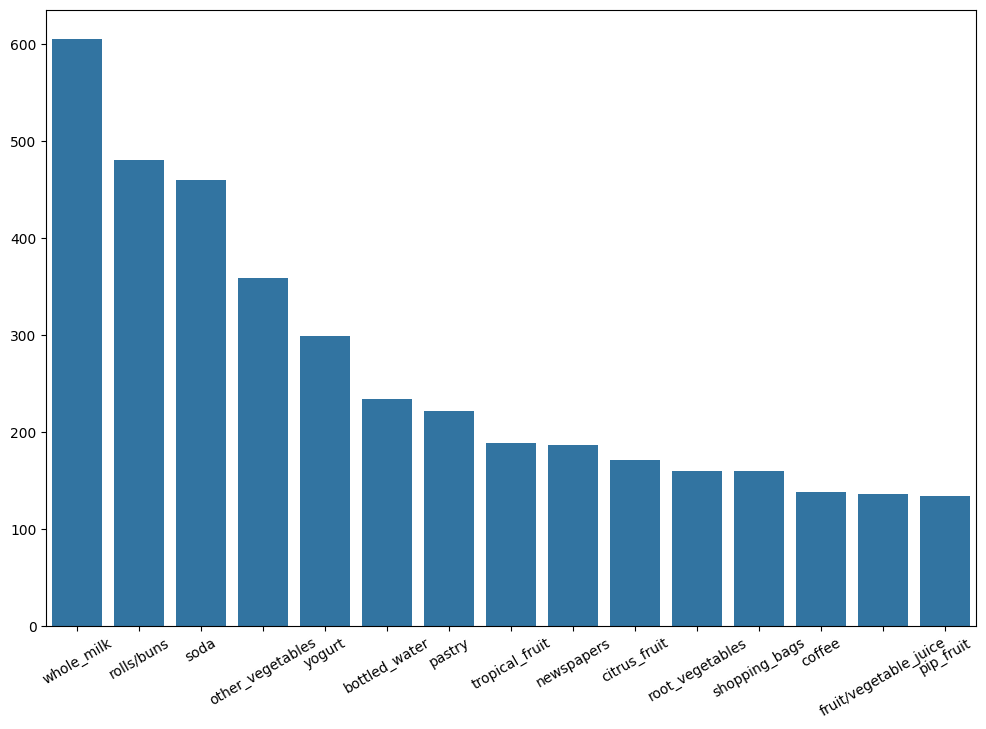

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

NUM_MOST_COMMON = 15

products = [occurance[0] for occurance in product_counter.most_common(NUM_MOST_COMMON)]
counts = [occurance[1] for occurance in product_counter.most_common(NUM_MOST_COMMON)]

plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(x=products, y=counts)
bar_plot.set_xticklabels(products, rotation=30)
plt.show();

In [24]:
#bar chart of top-k pairs by support fraction

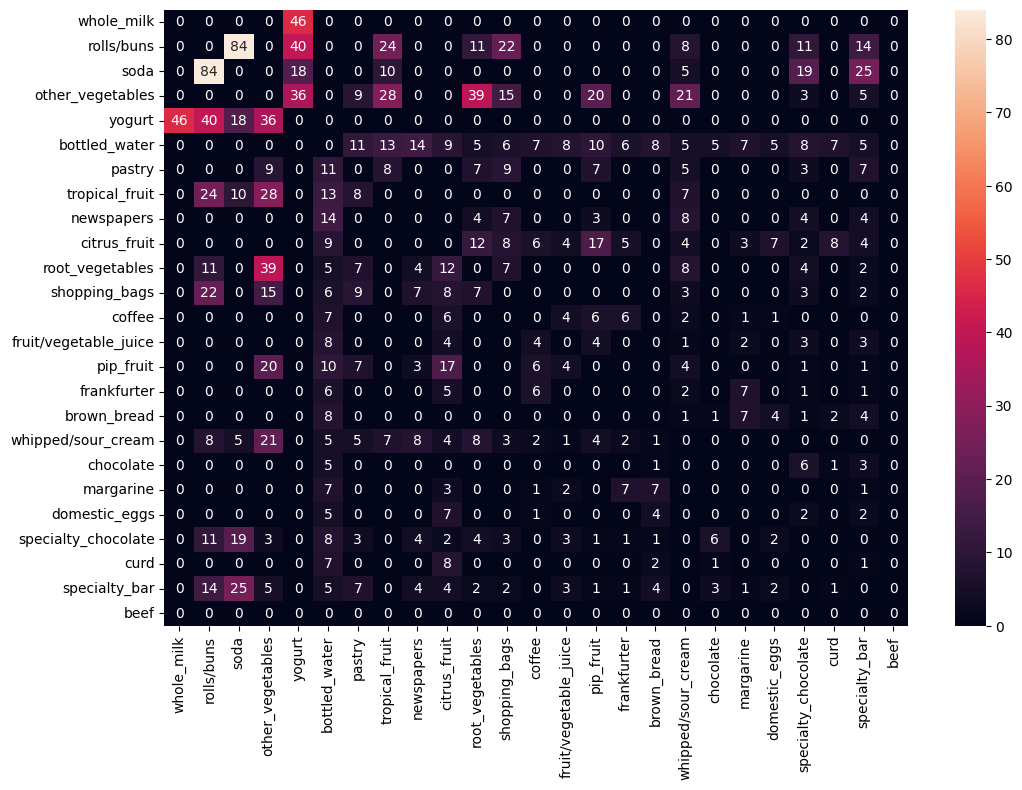

In [25]:
NUM_MOST_FREQUENT = 25
products = [occurance[0] for occurance in product_counter.most_common(NUM_MOST_FREQUENT)]

df_cooccur = pd.DataFrame(data=np.zeros((NUM_MOST_FREQUENT, NUM_MOST_FREQUENT), dtype=np.int16),
                          columns=products, index=products)

for product1, product2 in combinations(products, 2):
    num_occurance = pair_counter.get((product1, product2), 0)
    df_cooccur.at[product1, product2] = num_occurance
    df_cooccur.at[product2, product1] = num_occurance

plt.figure(figsize=(12, 8))
sns.heatmap(df_cooccur, annot=True)
plt.show();

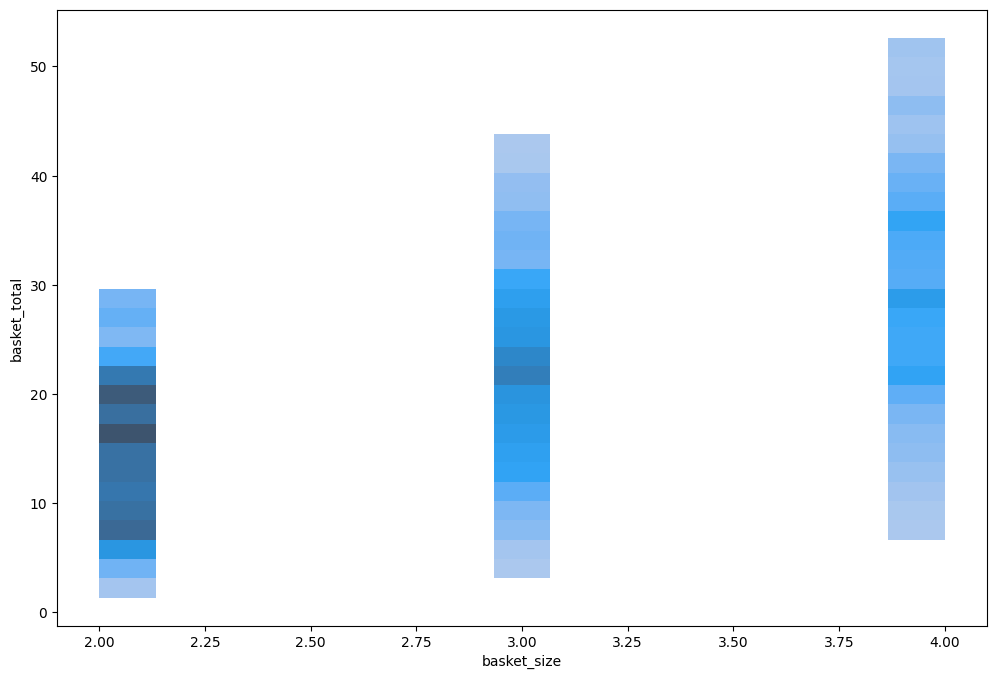

In [26]:
plt.figure(figsize=(12, 8))
sns.histplot(x='basket_size', y='basket_total', data=df)
plt.show();

In [27]:
NUM_PAIRS = 20

top_pairs = pair_counter.most_common(NUM_PAIRS)

products = set()
for occurance in top_pairs:
    products.update(occurance[0])
products


{'bottled_water',
 'brown_bread',
 'frankfurter',
 'newspapers',
 'other_vegetables',
 'pastry',
 'rolls/buns',
 'root_vegetables',
 'soda',
 'tropical_fruit',
 'whole_milk',
 'yogurt'}

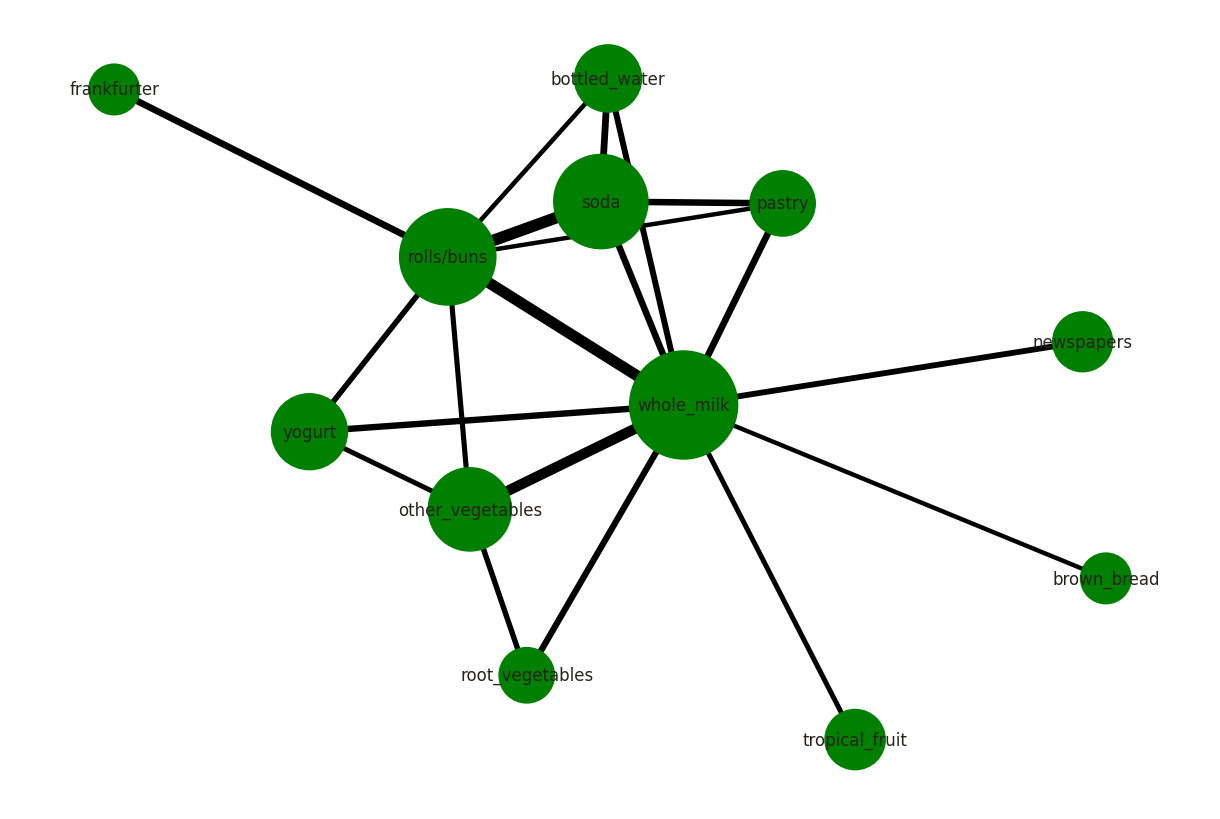

In [28]:
import networkx as nx

G = nx.Graph()

for product in products:
    G.add_node(product, weight=product_counter.get(product, 1))

for occurance in top_pairs:
    G.add_edge(*occurance[0], weight=occurance[1])

node_sizes = [product_counter.get(product, 1)*10 for product in G.nodes()]
edge_sizes = [G[u][v]['weight']/10 for u, v in G.edges()]

plt.figure(figsize=(12, 8))
spring_graph = nx.spring_layout(G)
nx.draw(G, spring_graph, node_size=node_sizes, width=edge_sizes, 
        with_labels=True, node_color='green', edge_color='black', 
        font_color='#28231D')
plt.show();

# Extensions